In [35]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init
import gpytorch

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

import tqdm


In [36]:
num_seeds = 30
seed = 0
# Load fullstate
data_fullstate = np.empty(num_seeds, dtype=object)
data_no_joint_pos = np.empty(num_seeds, dtype=object)
data_no_joint_vel = np.empty(num_seeds, dtype=object)
data_no_action = np.empty(num_seeds, dtype=object)
data_no_imu = np.empty(num_seeds, dtype=object)
data_no_fc = np.empty(num_seeds, dtype=object)
for i in range(num_seeds):
    data_fullstate[i] = np.load(f"../data/HEBB-full/HEBB-FULL_STATE-seed_{seed}-fullstate-rand-{i}.npz")
    # data_no_joint_pos[i] = np.load(f"data/HEBB-full_state/HEBB-FULL-STATE_seed-{seed}-no_joint_pos-rand-{i}.npz")
    # data_no_joint_vel[i] = np.load(f"data/HEBB-full_state/HEBB-FULL-STATE_seed-{seed}-no_joint_vel-rand-{i}.npz")
    # data_no_action[i] = np.load(f"data/HEBB-full_state/HEBB-FULL-STATE_seed-{seed}-no_action-rand-{i}.npz")
    # data_no_imu[i] = np.load(f"data/HEBB-full_state/HEBB-FULL-STATE_seed-{seed}-no_imu-rand-{i}.npz")
    # data_no_fc[i] = np.load(f"data/HEBB-full_state/HEBB-FULL-STATE_seed-{seed}-no_fc-rand-{i}.npz")

In [37]:
fc_data = data_fullstate[0]["fc"].reshape(-1, 4)
fc_data = fc_data[:500 , :]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], ['joint0_m', 'joint0_h', 'joint0_f', 'joint1_rf', 'joint1_lf', 'joint1_rh', 'joint1_lh', 'joint2_rf', 'joint2_lf', 'joint2_rh', 'joint2_lh', 'joint3_rf', 'joint3_lf', 'joint3_rh', 'joint3_lh', 'joint4_rf', 'joint4_lf', 'joint4_rh', 'joint4_lh'])
[DEBUGGING] Joints name: ['joint0_m', 'joint0_h', 'joint0_f', 'joint1_rf', 'joint1_lf', 'joint1_rh', 'joint1_lh', 'joint2_rf', 'joint2_lf', 'joint2_rh', 'joint2_lh', 'joint3_rf', 'joint3_lf', 'joint3_rh', 'joint3_lh', 'joint4_rf', 'joint4_lf', 'joint4_rh', 'joint4_lh']

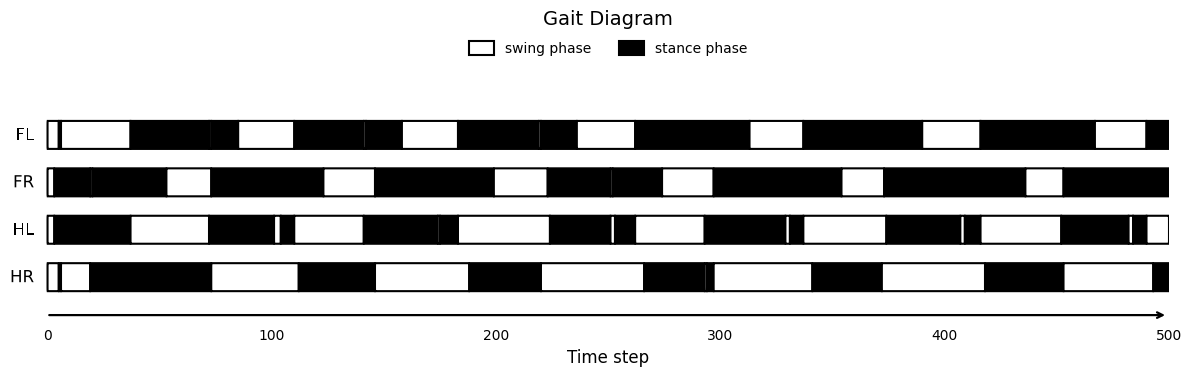

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Patch
from matplotlib.patheffects import withStroke

def plot_gait_blocks(fc_data, leg_labels=None, thr=0.5):
    """
    fc_data: (T, 4) array. 1=stance (contact), 0=swing.
    leg_labels: optional list of 4 labels (e.g., ["Leg 0","Leg 1","Leg 2","Leg 3"])
    thr: threshold if fc_data is float.
    """
    fc = (fc_data > thr).astype(int)  # binary
    T, L = fc.shape
    if leg_labels is None:
        leg_labels = [f"Leg {i}" for i in range(L)]

    # Layout
    row_h = 1.0          # vertical spacing per leg
    box_h = 0.55         # box height
    left_pad = 6
    right_pad = 0.6
    corner = 0.15        # rounding (0..1)

    fig_h = 1.3 + L*0.75
    fig, ax = plt.subplots(figsize=(12, fig_h))

    # Helper: contiguous segments (start, end, value)
    def segments(a):
        if T == 0: return []
        change = np.diff(a, prepend=a[0])
        idx = np.flatnonzero(change != 0)
        starts = np.r_[0, idx]
        ends = np.r_[starts[1:] - 1, T - 1]
        vals = a[starts]
        return list(zip(starts, ends, vals))

    for leg in range(L):
        y_center = (L-1 - leg) * row_h
        # remove this line if you don't want the grey center line:
        # ax.hlines(y_center, -0.5, T-0.5, lw=0.8, color="0.8")

        for s, e, v in segments(fc[:, leg]):
            x0 = s
            w  = e - s + 1
            face = "black" if v == 1 else "white"
            rect = FancyBboxPatch(
                (x0, y_center - box_h/2),
                w, box_h,
                boxstyle=f"round,pad=0.02,rounding_size={box_h*corner}",
                facecolor=face,
                edgecolor="black",
                linewidth=1.5,
            )
            ax.add_patch(rect)

        # leg label
        ax.text(-left_pad, y_center, leg_labels[leg],
                va="center", ha="right", fontsize=12,
                path_effects=[withStroke(linewidth=3, foreground="white")])

    # Axes
    ax.set_xlim(-0.5, T - 0.5 + right_pad)
    ax.set_ylim(-row_h, (L-1)*row_h + row_h)
    ax.set_yticks([])
    ax.set_xlabel("Time step", fontsize=12)

    # Legend ABOVE the title
    legend_handles = [
        Patch(facecolor="white", edgecolor="black", label="swing phase", linewidth=1.5),
        Patch(facecolor="black", edgecolor="black", label="stance phase", linewidth=1.5),
    ]

    ax.legend(handles=legend_handles,
            loc="upper center",
            ncol=2,
            frameon=False,
            bbox_to_anchor=(0.5, 1.25),   # move legend higher (↑)
            handlelength=1.8, handleheight=1.2)

    # Title under legend (increase pad to add more space)
    ax.set_title("Gait Diagram", fontsize=14, pad=45)

    # Time arrow
    ax.annotate("", xy=(T-0.5, -row_h*0.8), xytext=(-0.5, -row_h*0.8),
                arrowprops=dict(arrowstyle="->", lw=1.6, color="black"))
    # ax.text((T-1)/2, -row_h*1.05, "Time", ha="center", va="top", fontsize=12)

    # Clean look
    ax.spines[['left','right','top','bottom']].set_visible(False)
    ax.tick_params(axis='x', length=0)
    plt.tight_layout(rect=[0,0,1,0.9])
    plt.show()


# --- usage ---
fc_data = data_fullstate[0]["fc"].reshape(-1, 4)
fc_data = fc_data[:1000, :]
plot_gait_blocks(fc_data, leg_labels=["FL","FR","HL","HR"])
